In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils as u
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.utils import *
import keras
from tensorflow.keras.optimizers import *
from keras.utils import np_utils as u
from keras import backend as K
from keras import *
import matplotlib.pyplot as plt


smooth = 0.0000001

def aspp(x,out_shape):
  b0=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(x)
  b0=BatchNormalization()(b0)
  b0=Activation("relu")(b0)
  b1=DepthwiseConv2D((3,3),dilation_rate=(1,1),padding="same",use_bias=False)(x)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)
  b1=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b1)
  b1=BatchNormalization()(b1)
  b1=Activation("relu")(b1)

  b2=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)
  b2=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b2)
  b2=BatchNormalization()(b2)
  b2=Activation("relu")(b2)

  b3=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)
  b3=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b3)
  b3=BatchNormalization()(b3)
  b3=Activation("relu")(b3)

  b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
  b4=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b4)
  b4=BatchNormalization()(b4)
  b4=Activation("relu")(b4)

  return x

def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def bn_relu(input_tensor):
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)

def contr_arm(input_tensor, filters, kernel_size ):
    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x2 = SeparableConv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)
    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 =SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x

def improve_ff_block(input_tensor1, pure_ff):
    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))

    conv6  = aspp(conv6,input_rows/32)

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])



model = model_arch(input_rows=384, input_cols=384, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import random
from keras.callbacks import TensorBoard
#from keras import backend as K
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import sys

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH_R = '/content/gdrive/MyDrive/dataset/B4/train/'
TRAIN_PATH_G = '/content/gdrive/MyDrive/dataset/B3/train/'
TRAIN_PATH_B = '/content/gdrive/MyDrive/dataset/B2/train/'

TEST_PATH_R = '/content/gdrive/MyDrive/dataset/B4/test/'
TEST_PATH_G = '/content/gdrive/MyDrive/dataset/B3/test/'
TEST_PATH_B = '/content/gdrive/MyDrive/dataset/B2/test/'

In [ ]:
X_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

tr=np.zeros(350)
te=np.zeros(10)

for i in range(350):
       tr[i]=i;
for i in range(10):
       te[i]=i;


for n, id_ in tqdm(enumerate(tr),total=350):
       red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')

       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb)
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       X_train[n] = img_b
       mask = imread('/content/gdrive/MyDrive/dataset/BQA/train/' + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       Y_train[n] =mask1/255.0
       for io in range(256):
          for jo in range(256):
           if (Y_train[n][io][jo]>0.3):
             Y_train[n][io][jo]=1
           else:
             Y_train[n][io][jo]=0

X_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []

for n, id_ in tqdm(enumerate(te),total=10):
       red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
       green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
       blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb)
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       X_test[n] = img_b

       mask = imread('/content/gdrive/MyDrive/dataset/BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       Y_test[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_test[n][io][jo]>0.3):
             Y_test[n][io][jo]=1
           else:
             Y_test[n][io][jo]=0


results = model.fit(X_train, Y_train, validation_split=b05, batch_size=2, epochs=50, verbose=1)


preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.95):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_acc = model.evaluate(X_test, Y_test, verbose=1)

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 1/50
166/166 [==============================] - 66s 209ms/step - loss: 0.5697 - jacc_coef: 0.5697 - accuracy: 0.8642 - val_loss: 0.9766 - val_jacc_coef: 0.9766 - val_accuracy: 0.6732
Epoch 2/50
166/166 [==============================] - 34s 204ms/step - loss: 0.3451 - jacc_coef: 0.3451 - accuracy: 0.9438 - val_loss: 0.9979 - val_jacc_coef: 0.9979 - val_accuracy: 0.6732
Epoch 3/50
166/166 [==============================] - 34s 202ms/step - loss: 0.2968 - jacc_coef: 0.2968 - accuracy: 0.9558 - val_loss: 0.9986 - val_jacc_coef: 0.9986 - val_accuracy: 0.6732
Epoch 4/50
166/166 [==============================] - 34s 203ms/step - loss: 0.2763 - jacc_coef: 0.2763 - accuracy: 0.9580 - val_loss: 0.5551 - val_jacc_coef: 0.5551 - val_accuracy: 0.8527
Epoch 5/50
166/166 [==============================] - 34s 203ms/step - loss: 0.2524 - jacc_coef: 0.2524 - accuracy: 0.9626 - val_loss: 0.2216 - val_jacc_coef: 0.2216 - val_accuracy: 0.9491
Epoch 6/50
166/166 [==============================] - 3

In [ ]:
print("Train Accuracy",train_acc[2])
print("Test Accuracy",test_acc[2])


Train Accuracy 0.9694586992263794
Test Accuracy 0.9650894403457642


In [ ]:
from sklearn.metrics import confusion_matrix

def precision(gt,mask):
 gt = gt.flatten()
 mask = mask.flatten()
 tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
 prec = tp/(tp+fp)
 return(prec)

####recall---
def recall(gt,mask):
 gt = gt.flatten()
 mask = mask.flatten()
 tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
 rec = tp/(tp+fn)
 return(rec)

###f1 score--

def f1_score(prec,rec):
 f1 = 2*(prec*rec)/(prec+rec)
 return f1



def Overall(gt,mask):
    gt = gt.flatten()
    mask = mask.flatten()
    tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
    rec = (tp+tn)/(tp+fp+fn+tn)
    return(rec)

sum = 0
for i in range(len(Y_test)):
 sum = sum + precision(Y_test[i],preds_test_t[i])
prec = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
 sum = sum + recall(Y_test[i],preds_test_t[i])
rec = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
 sum = sum + jaccard(Y_test[i],preds_test_t[i])
jaccard1 = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
 sum = sum + Overall(Y_test[i],preds_test_t[i])
Overall1 = sum/len(Y_test)

f1 = f1_score(prec,rec)

print("final f1", f1)
print("final precision",prec)
print("final recall",rec)

Jaccard Index 0.6286249557980772
final f1 0.7962316110880504
final precision 0.7842470044198777
final recall 0.8085881918350049


Accuracy is: 0.9677322387695313


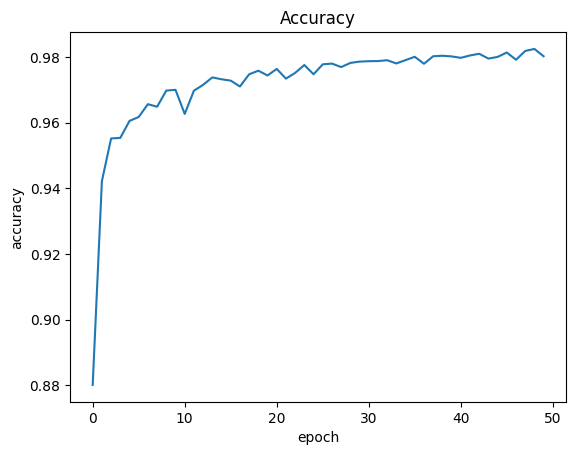

In [ ]:
results.history['accuracy']
print("Accuracy is:",Overall1)

from matplotlib import pyplot
pyplot.plot(results.history['accuracy'])
pyplot.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
pyplot.show()

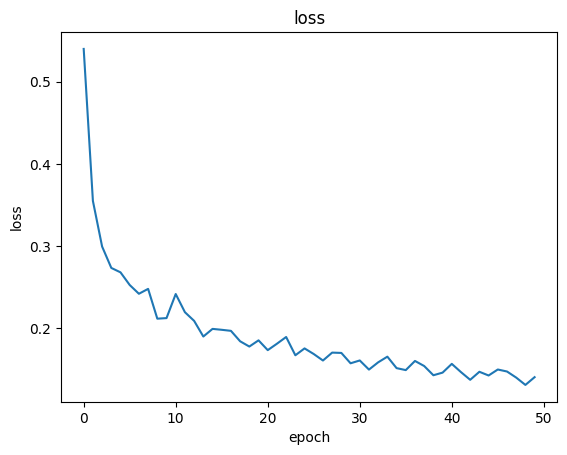

In [ ]:
results.history['loss']
#print("loss is:" , val_loss)

pyplot.plot(results.history["loss"])
pyplot.title("loss")
plt.ylabel("loss")
plt.xlabel("epoch")
pyplot.show()

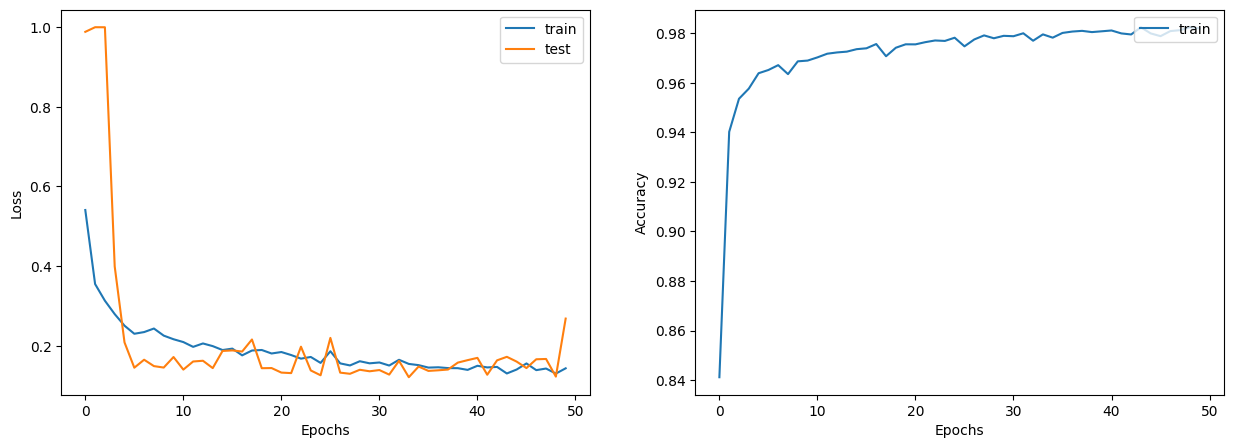

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    #ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
    #plt.savefig()




display_learning_curves(results)